In [1]:
%whos

Interactive namespace is empty.


In [2]:
!nproc

32


In [3]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            62Gi       1.9Gi        40Gi        12Mi        21Gi        60Gi
Swap:          8.0Gi          0B       8.0Gi


In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# GPU Verification

In [1]:
!nvidia-smi

Mon Feb  3 17:10:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off |   00000000:01:00.0 Off |                    0 |
| 30%   36C    P8             30W /  300W |      12MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

<br/>

<br/>

<br/>

In [2]:
# not needed on Colab
# !pip install -q xgboost pandas numpy scikit-learn

In [3]:
# !pip uninstall -y scikit-learn
# !pip install -q scikit-learn==1.5.2

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# NVIDA RAPIDS Verification

In [4]:
# 0. Enable NVIDIA GPU in Colab
# a. Runtime OR Resources Tool > Change runtime type

In [5]:
# 1. verify GPU and CUDA
# a. nvidia-smi
# b. nvcc --version

In [6]:
# 2. verify NVIDIA RAPIDS cuDF
# a. !pip freeze | grep cudf
# b. %load_ext cudf.pandas
# c. import pandas as pd
# d. %whos

In [7]:
%load_ext cudf.pandas

In [8]:
import xgboost as xgb
import pandas as pd
import numpy as np

pd

<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

In [9]:
# 3. verify lastest XGBoost version
# a. get latest version - rapids.ai
# b. pip freeze | grep xgboost
# c. import xgboost as xgb ; xgb.__version__

In [10]:
import xgboost as xgb ; xgb.__version__

'2.1.3'

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# City of Chicago Taxi Trips Data
##### Dowload Data From Here:
https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/data_preview


In [15]:
# !cp /content/drive/MyDrive/Taxi_Trips__2013-2023__20241218.csv .

In [11]:
!wc -l Taxi_Trips__2013-2023__20241218.csv

1972429 Taxi_Trips__2013-2023__20241218.csv


In [12]:
# xgb_device = "cpu"
xgb_device = "cuda"
xgb_device

'cuda'

In [13]:
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

<br/>

<br/>

<br/>

# CSV

In [14]:
%%time

start = time()
# RAPIDS OFF  - 22.04
# RAPIDS A100 - 0.408 (x33) / 1.95 ()

df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data

CPU times: user 242 ms, sys: 228 ms, total: 470 ms
Wall time: 248 ms


In [15]:
%%time
# RAPIDS OFF  - 22.04
# RAPIDS A100 - 0.051

df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name

df = df[df["trip_ttl"]>0]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df.drop(columns=["trip_ttl"])
y = df["trip_ttl"]

CPU times: user 80 ms, sys: 19.1 ms, total: 99.1 ms
Wall time: 95.2 ms


In [16]:
%%time

start = time()
# RAPIDS OFF  - 22.04
# RAPIDS A100 - 0.408 (x33) / 1.95 (x11)

df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data

df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name

df = df[df["trip_ttl"]>0]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df.drop(columns=["trip_ttl"])
y = df["trip_ttl"]

time() - start

CPU times: user 240 ms, sys: 167 ms, total: 408 ms
Wall time: 194 ms


0.1939387321472168

In [17]:
len(df)

1971068

<br/>

<br/>

<br/>

<br/>

# Mean Model

In [18]:
y.mean().round(2).item()

17.58

In [19]:
%%time

# RAPIDS OFF  - 1.22
# RAPIDS A100 - 0.724

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mean_fold_results = {"avg":[], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

for fold, (train_index, test_index) in enumerate(kf.split(y)):

  # get folds
  y_train, y_true = y[train_index], y[test_index]

  # "mean model"
  y_pred = y_train.mean()
  mean_fold_results["avg"].append(y_pred)

  # calculate metrics
  mse = ((y_true - y_pred) ** 2).mean()
  mean_fold_results["mse"].append(mse)
  mean_fold_results["rmse"].append(mse  ** 0.5)
  mae = (y_true - y_pred).abs().mean()
  mean_fold_results["mae"].append(mae)
  ss_residual = ((y_true - y_pred) ** 2).sum()
  ss_total = ((y_true - y_true.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  mean_fold_results["r2"].append(1 - (ss_residual / ss_total))
  mean_fold_results["max_err"].append((y_true - y_pred).abs().max())

mean_fold_results_df = pd.DataFrame(mean_fold_results)
mean_fold_results_df

CPU times: user 268 ms, sys: 65.7 ms, total: 334 ms
Wall time: 324 ms


,avg,mse,rmse,mae,r2,max_err
0,17.532107,9141.875107,95.613153,13.542402,-6.023739e-06,9782.767893
1,17.617675,7639.707685,87.405421,13.250784,-4.884284e-06,9882.682325
2,17.616017,6383.971635,79.899760,13.259757,-5.354304e-06,9034.833983
3,17.549724,8855.465930,94.103485,13.516449,-2.426406e-06,9957.770276
4,17.579680,8401.307659,91.658647,13.400753,-1.217141e-09,9682.670320


In [20]:
mean_results_df = pd.DataFrame({'model': 'mean',**mean_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': mean_fold_results_df['max_err'].max()}, index=[0])
mean_results_df.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,mean,17.58,8084.47,89.74,13.39,-0.0,9957.77


<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# Median Model

In [21]:
y.median()

np.float64(9.75)

In [22]:
%%time
# RAPIDS OFF  - 0.959
# RAPIDS A100 -

median_fold_results = {"avg":[], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}
for fold, (train_index, test_index) in enumerate(kf.split(y)):

  # get folds
  y_train, y_true = y[train_index], y[test_index]

  # "median model"
  y_pred = y_train.median()
  median_fold_results["avg"].append(y_pred)

  # calculate metrics
  mse = ((y_true - y_pred) ** 2).mean()
  median_fold_results["mse"].append(mse)
  median_fold_results["rmse"].append(mse ** 0.5)
  mae = (y_true - y_pred).abs().mean()
  median_fold_results["mae"].append(mae)
  ss_residual = ((y_true - y_pred) ** 2).sum()
  ss_total = ((y_true - y_true.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  median_fold_results["r2"].append(1 - (ss_residual / ss_total))
  median_fold_results["max_err"].append((y_true - y_pred).abs().max())

median_fold_results_df = pd.DataFrame(median_fold_results)

CPU times: user 257 ms, sys: 44.9 ms, total: 302 ms
Wall time: 291 ms


In [23]:
median_results_df = pd.DataFrame({'model': 'median', **median_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': median_fold_results_df['max_err'].max()}, index=[0])
pd.concat([mean_results_df, median_results_df]).round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,mean,17.58,8084.47,89.74,13.39,-0.00,9957.77
0,median,9.75,8145.75,90.08,10.52,-0.01,9965.57


<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# Naive XGBoost
##### Min Feature Engineering and no Hyperparameter Tuning

In [24]:
%%time

# RAPIDS OFF  - 48.2, 40.5
# RAPIDS A100 - 0.597 (x68)

df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data

df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name

df = df[df["trip_ttl"]>0]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])
df = df.drop(columns=["Trip ID", "Taxi ID", "Pickup Centroid Location", "Dropoff Centroid  Location", "Payment Type", "Company"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip Start Timestamp"] = (df["Trip Start Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df["Trip End Timestamp"] = (df["Trip End Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

y = df["trip_ttl"]
X = df.drop(columns=["trip_ttl"])

CPU times: user 310 ms, sys: 149 ms, total: 458 ms
Wall time: 253 ms


In [25]:
%%time

# RAPIDS OFF  - 117.26
# RAPIDS A100 - 6.66 (x17), 5.35

import xgboost as xgb

xgb_naive_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

for fold, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # train
  xgb_model = xgb.XGBRegressor(device=xgb_device)

  xgb_model.fit(X_train, y_train)
  y_pred = xgb_model.predict(X_test)
  xgb_naive_fold_results["avg"].append(y_pred.mean())

  # metrics
  mse = ((y_test - y_pred) ** 2).mean()
  xgb_naive_fold_results["mse"].append(mse)
  xgb_naive_fold_results["rmse"].append(mse ** 0.5)
  mae = (y_test - y_pred).abs().mean()
  xgb_naive_fold_results["mae"].append(mae)
  ss_residual = ((y_test - y_pred) ** 2).sum()
  ss_total = ((y_test - y_test.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  xgb_naive_fold_results["r2"].append(1 - (ss_residual / ss_total))
  xgb_naive_fold_results["max_err"].append((y_test - y_pred).abs().max())

CPU times: user 3.22 s, sys: 502 ms, total: 3.73 s
Wall time: 2.46 s


### All Naïve Results

In [26]:
xgb_naïve_fold_results_df = pd.DataFrame(xgb_naive_fold_results)
xgb_naïve_results_df = pd.DataFrame({'model': 'xgb_naïve',**xgb_naïve_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_naïve_fold_results_df['max_err'].max()}, index=[0])
all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df]).sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True])
all_results.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,xgb_naïve,17.58,7055.60,83.87,5.16,0.13,9788.08
0,median,9.75,8145.75,90.08,10.52,-0.01,9965.57
0,mean,17.58,8084.47,89.74,13.39,-0.00,9957.77


<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

### Feature Importance

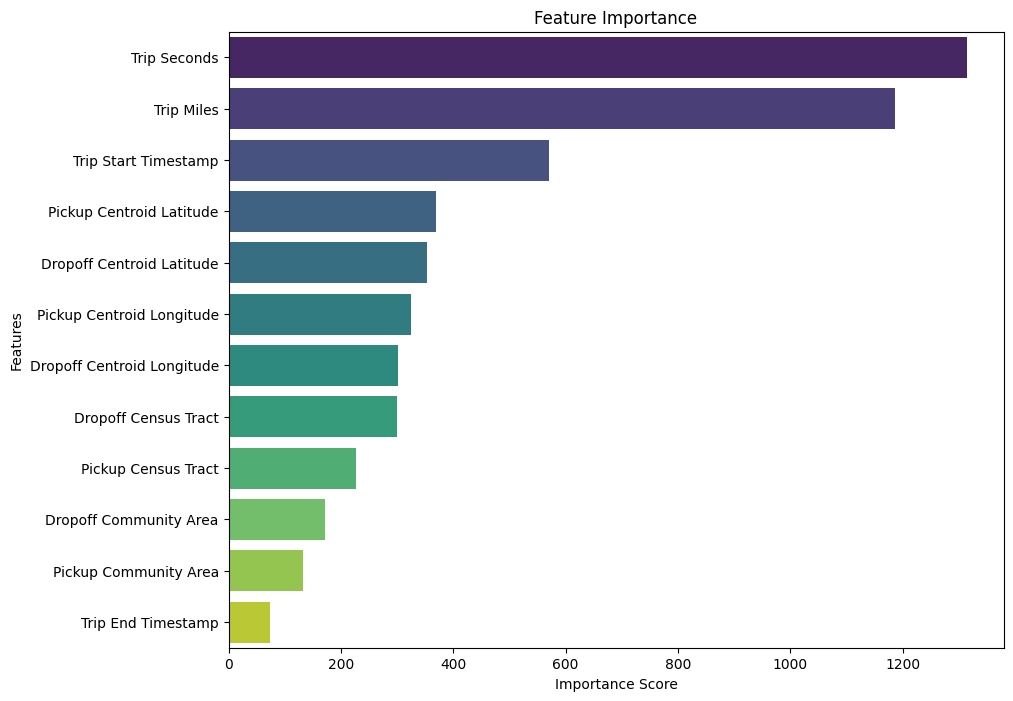

In [27]:
booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')  # You can also use 'gain', 'cover', etc.

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette="viridis", dodge=False, legend=False)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

<br/>

<br/>

<br/>

# XGBoost + Feature Engineering

In [28]:
%%time

# RAPIDS OFF  - 20.28
# RAPIDS A100 - 0.40 (x50)

df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data

df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name

df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])

df = df.drop(columns=["Trip ID", "Taxi ID"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")

df = df[df["trip_ttl"]>0]

CPU times: user 257 ms, sys: 131 ms, total: 389 ms
Wall time: 185 ms


### Feature Classification

In [29]:
%%time

# RAPIDS OFF  - 1.75
# RAPIDS A100 - 0.0247 (x70)

df.nunique().sort_values()

CPU times: user 18.5 ms, sys: 3.2 ms, total: 21.7 ms
Wall time: 18.8 ms


Payment Type                      9
Company                          42
Pickup Community Area            77
Dropoff Community Area           77
Pickup Census Tract             292
Pickup Centroid Latitude        366
Pickup Centroid Longitude       366
Pickup Centroid Location        369
Dropoff Centroid Latitude       475
Dropoff Centroid Longitude      475
Dropoff Centroid  Location      480
Dropoff Census Tract            485
Trip Miles                     4532
trip_ttl                       6665
Trip Seconds                   8989
Trip Start Timestamp          19380
Trip End Timestamp            19405
dtype: int64

In [30]:
%%time

# RAPIDS OFF  - 0.31
# RAPIDS A100 - 0.0048 (x62)

target = ["trip_ttl"]
assert len(df[target]) > 0

num_cols = ["Pickup Centroid Latitude", "Pickup Centroid Longitude", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Trip Miles", "Trip Seconds", "Trip Start Timestamp", "Trip End Timestamp"]
assert len(df[num_cols]) > 0

cat_cols = list(set(df.columns) - set(target + num_cols))
assert len(df[cat_cols]) > 0
print(cat_cols)

assert len(df.columns) == len(target) + len(num_cols) + len(cat_cols)
assert len(target + num_cols + cat_cols) == len(set(target + num_cols + cat_cols))

['Pickup Community Area', 'Payment Type', 'Pickup Census Tract', 'Dropoff Community Area', 'Dropoff Census Tract', 'Dropoff Centroid  Location', 'Pickup Centroid Location', 'Company']
CPU times: user 5.55 ms, sys: 0 ns, total: 5.55 ms
Wall time: 4.7 ms


### Impute

In [31]:
%%time

# RAPIDS OFF  - 3.33
# RAPIDS A100 - 4.04

# impute num cols
for col in num_cols:
  df[col] = df[col].fillna(df[col].mean())

#impute cat cols
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

CPU times: user 1.22 s, sys: 230 ms, total: 1.45 s
Wall time: 1.44 s


### Outlier Analysis

In [32]:
%%time

# RAPIDS OFF  - 2.51
# RAPIDS A100 - 0.02 (x125)
df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles", "Payment Type"]]

CPU times: user 9.12 ms, sys: 2.74 ms, total: 11.9 ms
Wall time: 10.9 ms


,trip_ttl,Trip Seconds,Trip Miles,Payment Type
1000042,9975.32,1500.0,0.00,Cash
171827,9900.30,1158.0,0.00,Cash
1664624,9800.30,1074.0,0.00,Cash
285324,9746.85,1080.0,57.90,Credit Card
161771,9700.25,1007.0,0.00,Cash
...,...,...,...,...
1017382,0.01,40.0,0.00,Cash
1038230,0.01,38.0,0.09,Cash
1037939,0.01,38.0,0.01,Cash
1227769,0.01,36.0,0.04,Cash


In [33]:
%%time

# RAPIDS OFF  - 0.216
# RAPIDS A100 - 0.021

df = df[(df['Trip Seconds'] * df['Trip Miles']) > 0]

CPU times: user 11.7 ms, sys: 92 μs, total: 11.8 ms
Wall time: 9.07 ms


In [34]:
def filter_by_modified_z_score(df, column, threshold=4.0):
    # median and MAD (median abs deviation)
    median = df[column].median()
    mad = (df[column] - median).abs().median()
    return df[(0.6745 * (df[column] - median) / mad).abs() <= threshold]

In [35]:
%%time

# RAPIDS OFF  - 1.18
# RAPIDS A100 - 0.04 (x29)

df = filter_by_modified_z_score(df, "trip_ttl", threshold=3.5)
df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles"]]

CPU times: user 30.1 ms, sys: 5.01 ms, total: 35.1 ms
Wall time: 31 ms


,trip_ttl,Trip Seconds,Trip Miles
426325,26.60,2880.0,3.30
653444,26.60,2460.0,5.20
1871234,26.60,2340.0,5.50
1224153,26.60,2220.0,6.10
845132,26.60,2100.0,4.50
...,...,...,...
1944300,0.01,58.0,0.32
1528258,0.01,40.0,0.10
1038230,0.01,38.0,0.09
1037939,0.01,38.0,0.01


### Feature Extraction

In [36]:
%%time

# RAPIDS OFF  - 0.36, 0.25
# RAPIDS A100 - 0.0315 (x8)

df['avg_speed'] = df['Trip Miles'] / (df['Trip Seconds'] / 3600)
num_cols.append('avg_speed')

df['day_of_week'] = df['Trip Start Timestamp'].dt.dayofweek
df['hour_of_day'] = df['Trip Start Timestamp'].dt.hour
df['month'] = df['Trip Start Timestamp'].dt.month
df['year'] = df['Trip Start Timestamp'].dt.year
cat_cols.extend(['day_of_week', 'hour_of_day', 'month', 'year'])


# convert to timestamp seconds since epoch
df['Trip Start Timestamp'] = df['Trip Start Timestamp'].astype(int) // 10**9
df['Trip End Timestamp'] = df['Trip End Timestamp'].astype(int) // 10**9

num_cols.extend(['Trip Start Timestamp', 'Trip End Timestamp'])

CPU times: user 22.1 ms, sys: 983 μs, total: 23.1 ms
Wall time: 22.9 ms


### Encode Categorical Features

In [37]:
%%time

# RAPIDS OFF  - 2.39
# RAPIDS A100 - 0.268 (x9)

# target encode cat_cols
for col in cat_cols:
  df[col] = df[col].map(df.groupby(col)["trip_ttl"].mean())

CPU times: user 94.9 ms, sys: 10.5 ms, total: 105 ms
Wall time: 92.7 ms


In [38]:
%%time

# RAPIDS OFF  - 1.23, 0.833
# RAPIDS A100 - 0.00823 (x100)

pd.set_option('display.max_columns', None)

df.sort_values("trip_ttl", ascending=False)

CPU times: user 15.1 ms, sys: 6.05 ms, total: 21.2 ms
Wall time: 14.1 ms


,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,trip_ttl,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,avg_speed,day_of_week,hour_of_day,month,year
5665,1542992400,1542994200,1620.0,5.60,9.026736,13.491123,9.673293,9.515685,26.60,11.589782,9.991409,41.899156,-87.626211,9.026736,41.878667,-87.671654,13.491123,12.444444,10.034090,10.666388,10.287562,10.135737
27000,1541611800,1541612700,1140.0,6.90,11.230968,11.209385,9.673293,13.134676,26.60,11.589782,10.028170,41.899602,-87.633308,13.312175,41.975171,-87.687516,12.937062,21.789474,9.944505,10.666388,10.287562,10.135737
58577,1542400200,1542401100,960.0,7.20,11.230968,11.209385,9.636544,18.599468,26.60,11.589782,10.063929,41.878866,-87.625192,15.722639,41.794090,-87.592311,17.837765,27.000000,10.034090,10.690281,10.287562,10.135737
75585,1541952000,1541952900,1260.0,7.20,11.230968,11.209385,11.398014,14.519452,26.60,11.589782,9.789769,41.953582,-87.723452,11.390095,41.953582,-87.723452,14.437584,20.571429,10.561506,9.987022,10.287562,10.135737
80664,1541943000,1541943000,480.0,3.60,11.230968,11.209385,16.560212,9.141873,26.60,11.589782,10.063929,41.980264,-87.913625,19.607906,41.897622,-87.650391,8.712605,27.000000,10.561506,9.421587,10.287562,10.135737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953038,1549127700,1549128600,1581.0,21.89,14.084110,11.209385,16.560212,9.141873,0.01,8.846531,10.430743,41.979071,-87.903040,14.084110,41.897622,-87.650391,8.712605,49.844402,10.461210,10.666388,10.077806,9.969116
1953494,1548666000,1548666900,1211.0,7.33,14.084110,11.209385,16.560212,9.141873,0.01,8.846531,10.430743,41.979071,-87.903040,14.084110,41.897622,-87.650391,8.712605,21.790256,9.882814,9.812430,9.927262,9.969116
1957942,1549026900,1549028700,1818.0,13.11,11.230968,11.209385,16.560212,9.141873,0.01,8.846531,10.430743,41.980264,-87.913625,19.607906,41.897622,-87.650391,8.712605,25.960396,10.034090,9.421587,10.077806,9.969116
1963097,1549472400,1549472400,61.0,0.07,10.388689,10.567145,15.545739,12.695346,0.01,8.846531,10.430743,41.785999,-87.750934,10.388689,41.785999,-87.750934,10.567145,4.131148,9.944505,10.666388,10.077806,9.969116


In [39]:
%%time

# RAPIDS OFF  - 0.969
# RAPIDS A100 - 0.800

# remove nulls/inf
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df

CPU times: user 68.4 ms, sys: 9.07 ms, total: 77.4 ms
Wall time: 68.1 ms


,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,trip_ttl,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,avg_speed,day_of_week,hour_of_day,month,year
0,1.543099e+09,1.543099e+09,240.0,0.90,8.889187,8.399119,9.673293,8.648094,5.50,8.846531,9.918811,41.892508,-87.626215,8.889187,41.884987,-87.620993,8.399119,13.500000,10.461210,10.907608,10.287562,10.135737
1,1.543069e+09,1.543069e+09,342.0,0.91,8.840747,8.976772,9.636544,9.141873,7.00,8.846531,9.991409,41.884987,-87.620993,8.840747,41.891972,-87.612945,8.976772,9.578947,10.461210,9.590097,10.287562,10.135737
2,1.542648e+09,1.542648e+09,419.0,0.82,9.269435,11.209385,9.933901,8.648094,7.70,11.589782,10.063929,41.879255,-87.642649,9.269435,41.880994,-87.632746,8.712605,7.045346,9.882814,10.666388,10.287562,10.135737
3,1.542815e+09,1.542816e+09,479.0,1.37,8.840747,8.697326,9.636544,9.141873,9.75,11.589782,9.991409,41.884987,-87.620993,8.840747,41.895033,-87.619711,8.697326,10.296451,9.944505,9.706529,10.287562,10.135737
4,1.542604e+09,1.542605e+09,1038.0,8.74,11.230968,11.209385,11.932033,13.692171,23.75,8.846531,10.063929,41.954028,-87.763399,11.920188,41.980264,-87.913625,18.763583,30.312139,9.882814,10.416209,10.287562,10.135737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972423,1.549474e+09,1.549475e+09,1005.0,3.20,13.677037,8.411083,11.556345,9.141873,11.75,8.846531,9.918811,41.938232,-87.646782,13.677037,41.892042,-87.631864,8.411083,11.462687,9.944505,10.666388,10.077806,9.969116
1972424,1.549489e+09,1.549490e+09,268.0,0.88,8.840747,8.978773,9.636544,9.141873,8.00,11.589782,10.140592,41.884987,-87.620993,8.840747,41.898332,-87.620763,8.978773,11.820896,9.944505,10.876360,10.077806,9.969116
1972425,1.549735e+09,1.549735e+09,450.0,1.28,9.026736,8.733624,9.673293,9.141873,10.05,11.007876,10.063929,41.899156,-87.626211,9.026736,41.890922,-87.618868,8.733624,10.240000,10.461210,10.594743,10.077806,9.969116
1972426,1.549306e+09,1.549307e+09,1288.0,4.10,11.230968,15.991460,9.636544,15.621674,14.75,8.846531,9.789769,41.880994,-87.632746,8.827250,41.920452,-87.679955,15.991460,11.459627,9.882814,10.594743,10.077806,9.969116


### XGBoost Model

In [40]:
%%time

# RAPIDS OFF  - 102.90
# RAPIDS A100 - 6.33 (x16)
start = time()

X = df.drop(columns=["trip_ttl"])
y = df["trip_ttl"]

xgb_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

for fold, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # train
  xgb_model = xgb.XGBRegressor(device=xgb_device)

  xgb_model.fit(X_train, y_train)
  y_pred = xgb_model.predict(X_test)
  xgb_fold_results["avg"].append(y_pred.mean())

  # metrics
  mse = ((y_test - y_pred) ** 2).mean()
  xgb_fold_results["mse"].append(mse)
  xgb_fold_results["rmse"].append(mse ** 0.5)
  mae = (y_test - y_pred).abs().mean()
  xgb_fold_results["mae"].append(mae)
  ss_residual = ((y_test - y_pred) ** 2).sum()
  ss_total = ((y_test - y_test.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  xgb_fold_results["r2"].append(1 - (ss_residual / ss_total))
  xgb_fold_results["max_err"].append((y_test - y_pred).abs().max())

xgb_fe_fold_results_df = pd.DataFrame(xgb_fold_results)

time() - start

CPU times: user 3.55 s, sys: 818 ms, total: 4.37 s
Wall time: 3.11 s


3.106651544570923

### Results

In [41]:
xgb_fe_results_df = pd.DataFrame({'model': 'xgb_fe',**xgb_fe_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_fe_fold_results_df['max_err'].max()}, index=[0])
all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df, xgb_fe_results_df]).sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True])
all_results.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,xgb_fe,10.08,1.12,1.06,0.70,0.94,28.07
0,xgb_naïve,17.58,7055.60,83.87,5.16,0.13,9788.08
0,median,9.75,8145.75,90.08,10.52,-0.01,9965.57
0,mean,17.58,8084.47,89.74,13.39,-0.00,9957.77


### Feature Importance

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')  # You can also use 'gain', 'cover', etc.

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

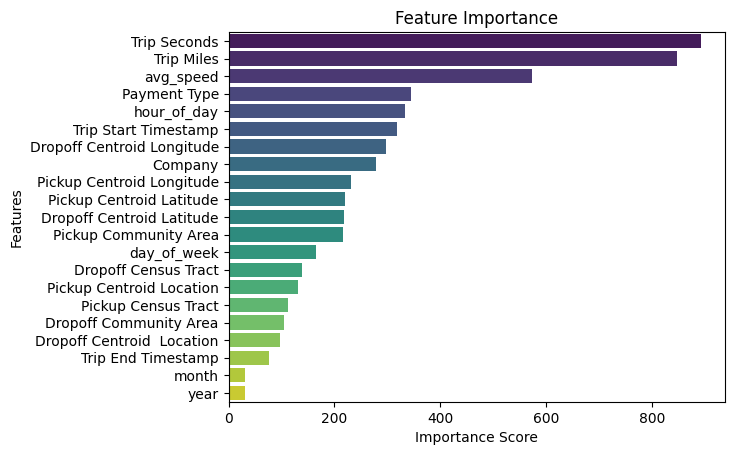

In [43]:
sns.barplot(x='Importance', y='Feature', data=importance_df.head(50), hue='Feature', palette="viridis", dodge=False, legend=False)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

<br/>

<br/>

# XGBoost Hyperparamter Tuning

In [44]:
%%time
# RAPIDS OFF  - 270.82 (100), 543.42 (250)
# RAPIDS A100 -             , 14.1(500)(x19)

X = df.drop(columns=["trip_ttl"])
y = df["trip_ttl"]

xgb_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

for fold, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # train
  xgb_model = xgb.XGBRegressor(device=xgb_device,
                               n_estimators=500,
                               learning_rate=0.05,
                               max_depth=6,
                               eval_metric="mae",
                               objective="reg:gamma",
                               min_child_weight=5
  )
  # xgb_model = xgb.XGBRegressor(device=xgb_device)

  xgb_model.fit(X_train, y_train)
  y_pred = xgb_model.predict(X_test)
  xgb_fold_results["avg"].append(y_pred.mean())

  # metrics
  mse = ((y_test - y_pred) ** 2).mean()
  xgb_fold_results["mse"].append(mse)
  xgb_fold_results["rmse"].append(mse ** 0.5)
  mae = (y_test - y_pred).abs().mean()
  xgb_fold_results["mae"].append(mae)
  ss_residual = ((y_test - y_pred) ** 2).sum()
  ss_total = ((y_test - y_test.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  xgb_fold_results["r2"].append(1 - (ss_residual / ss_total))
  xgb_fold_results["max_err"].append((y_test - y_pred).abs().max())

CPU times: user 7.98 s, sys: 896 ms, total: 8.87 s
Wall time: 7.14 s


In [45]:
xgb_tuned_fold_results_df = pd.DataFrame(xgb_fold_results)
xgb_tuned_results_df = pd.DataFrame({'model': 'xgb_tuned',**xgb_tuned_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_tuned_fold_results_df['max_err'].max()}, index=[0])

all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df, xgb_fe_results_df, xgb_tuned_results_df])[["model", "mae", "rmse", "mse", "r2", "max_err", "avg"]]
all_results.sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True]).round(3)

,model,mae,rmse,mse,r2,max_err,avg
0,xgb_tuned,0.692,1.051,1.105,0.945,23.547,10.080
0,xgb_fe,0.698,1.056,1.115,0.944,28.065,10.084
0,xgb_naïve,5.157,83.868,7055.597,0.125,9788.077,17.581
0,median,10.521,90.078,8145.749,-0.008,9965.570,9.750
0,mean,13.394,89.736,8084.466,-0.000,9957.770,17.579


<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# x20 Performance Boost - All Code

### RAPIDS OFF

In [46]:
226.7 / 10

22.669999999999998

### RAPIDS ON A100

In [47]:
10

10

<br/>

In [48]:
# !cp /content/drive/MyDrive/Taxi_Trips__2013-2023__20241218.csv .

In [49]:
xgb_device = "cpu"

# %load_ext cudf.pandas
# xgb_device = "cuda"

In [50]:
import pandas as pd
import numpy as np
import xgboost as xgb
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [51]:
start = time()
# RAPIDS OFF  - 243.32
# RAPIDS A100 - 9.91

#----------MEAN/MEDIAN DATA PREP--------------#
df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data
df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name
df = df[df["trip_ttl"]>0]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(0.8 * len(df))  # 80% train, 20% test
train_df = df[:split_index]
test_df = df[split_index:]
del df

X_test = test_df.drop(columns=["trip_ttl"])
y_test = test_df["trip_ttl"]

X_train = train_df.drop(columns=["trip_ttl"])
y_train = train_df["trip_ttl"]

#----------MEAN--------------#
mean_fold_results = {"avg":[], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}


y_pred = y_train.mean()
mean_fold_results["avg"].append(y_pred)

mse = ((y_test - y_pred) ** 2).mean()
mean_fold_results["mse"].append(mse)
mean_fold_results["rmse"].append(mse  ** 0.5)
mae = (y_test - y_pred).abs().mean()
mean_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
mean_fold_results["r2"].append(1 - (ss_residual / ss_total))
mean_fold_results["max_err"].append((y_test - y_pred).abs().max())


#----------MEDIAN--------------#
median_fold_results = {"avg":[], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

y_pred = y_train.median()
median_fold_results["avg"].append(y_pred)

mse = ((y_test - y_pred) ** 2).mean()
median_fold_results["mse"].append(mse)
median_fold_results["rmse"].append(mse ** 0.5)
mae = (y_test - y_pred).abs().mean()
median_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
median_fold_results["r2"].append(1 - (ss_residual / ss_total))
median_fold_results["max_err"].append((y_test - y_pred).abs().max())


#---------------------XGB NAIVE DATA PREP---------------------#
df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data
df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name
df = df[df["trip_ttl"]>0]
_ = df.sort_values(["trip_ttl"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles"]]

df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])
df = df.drop(columns=["Trip ID", "Taxi ID", "Pickup Centroid Location", "Dropoff Centroid  Location", "Payment Type", "Company"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip Start Timestamp"] = (df["Trip Start Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df["Trip End Timestamp"] = (df["Trip End Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(0.8 * len(df))  # 80% train, 20% test
train_df = df[:split_index]
test_df = df[split_index:]
del df

X_test = test_df.drop(columns=["trip_ttl"])
y_test = test_df["trip_ttl"]

X_train = train_df.drop(columns=["trip_ttl"])
y_train = train_df["trip_ttl"]


#----------------XGB NAIVE-------------------#
xgb_naive_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}


# train
xgb_model = xgb.XGBRegressor(device=xgb_device)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_naive_fold_results["avg"].append(y_pred.mean())

# metrics
mse = ((y_test - y_pred) ** 2).mean()
xgb_naive_fold_results["mse"].append(mse)
xgb_naive_fold_results["rmse"].append(mse ** 0.5)
mae = (y_test - y_pred).abs().mean()
xgb_naive_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
xgb_naive_fold_results["r2"].append(1 - (ss_residual / ss_total))
xgb_naive_fold_results["max_err"].append((y_test - y_pred).abs().max())


#----------------------XGB FEATURE ENGINEERING - DATA PREP-----------------------#
df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data
df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name
df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])
df = df.drop(columns=["Trip ID", "Taxi ID"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")

df = df[df["trip_ttl"]>0]
_ = df.nunique().sort_values()

target = ["trip_ttl"]
num_cols = ["Pickup Centroid Latitude", "Pickup Centroid Longitude", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Trip Miles", "Trip Seconds", "Trip Start Timestamp", "Trip End Timestamp"]
cat_cols = list(set(df.columns) - set(target + num_cols))

for col in num_cols:
  df[col] = df[col].fillna(df[col].mean())

df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles", "Payment Type"]]

df = df[(df['Trip Seconds'] * df['Trip Miles']) > 0]

def filter_by_modified_z_score(df, column, threshold=4.0):
    # median and MAD (median abs deviation)
    median = df[column].median()
    mad = (df[column] - median).abs().median()
    return df[(0.6745 * (df[column] - median) / mad).abs() <= threshold]

df = filter_by_modified_z_score(df, "trip_ttl", threshold=3.5)
_ = df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles"]]

### Feature Extraction

df['avg_speed'] = df['Trip Miles'] / (df['Trip Seconds'] / 3600)
num_cols.append('avg_speed')

df['day_of_week'] = df['Trip Start Timestamp'].dt.dayofweek
df['hour_of_day'] = df['Trip Start Timestamp'].dt.hour
df['month'] = df['Trip Start Timestamp'].dt.month
df['year'] = df['Trip Start Timestamp'].dt.year
cat_cols.extend(['day_of_week', 'hour_of_day', 'month', 'year'])

# convert to timestamp seconds since epoch
df['Trip Start Timestamp'] = df['Trip Start Timestamp'].astype(int) // 10**9
df['Trip End Timestamp'] = df['Trip End Timestamp'].astype(int) // 10**9

num_cols.extend(['Trip Start Timestamp', 'Trip End Timestamp'])

for col in cat_cols:
  df[col] = df[col].map(df.groupby(col)["trip_ttl"].mean())

_ = df.sort_values("trip_ttl", ascending=False)

df = df.replace([np.inf, -np.inf], np.nan).dropna()

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(0.8 * len(df))  # 80% train, 20% test
train_df = df[:split_index]
test_df = df[split_index:]
del df

X_test = test_df.drop(columns=["trip_ttl"])
y_test = test_df["trip_ttl"]

X_train = train_df.drop(columns=["trip_ttl"])
y_train = train_df["trip_ttl"]


#--------------------XGB FE----------------------------#
xgb_fe_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

# train
xgb_model = xgb.XGBRegressor(device=xgb_device)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_fe_fold_results["avg"].append(y_pred.mean())

# metrics
mse = ((y_test - y_pred) ** 2).mean()
xgb_fe_fold_results["mse"].append(mse)
xgb_fe_fold_results["rmse"].append(mse ** 0.5)
mae = (y_test - y_pred).abs().mean()
xgb_fe_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
xgb_fe_fold_results["r2"].append(1 - (ss_residual / ss_total))
xgb_fe_fold_results["max_err"].append((y_test - y_pred).abs().max())


#--------------XGB HYPERPARAMETER TUNING--------------#
xgb_tune_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

# train
xgb_model = xgb.XGBRegressor(device=xgb_device,
                              n_estimators=500,
                              learning_rate=0.05,
                              max_depth=6,
                              eval_metric="mae",
                              objective="reg:gamma",
                              min_child_weight=5
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_tune_fold_results["avg"].append(y_pred.mean())

mse = ((y_test - y_pred) ** 2).mean()
xgb_tune_fold_results["mse"].append(mse)
xgb_tune_fold_results["rmse"].append(mse ** 0.5)
mae = (y_test - y_pred).abs().mean()
xgb_tune_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
xgb_tune_fold_results["r2"].append(1 - (ss_residual / ss_total))
xgb_tune_fold_results["max_err"].append((y_test - y_pred).abs().max())

time() - start

/home/will/git/Accelerated_Data_Sci/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:12:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


7.995441436767578

<br/>

<br/>

<br/>

<br/>

### results

In [52]:
del xgb_fold_results

In [53]:
mean_fold_results_df = pd.DataFrame(mean_fold_results)
mean_results_df = pd.DataFrame({'model': 'mean',**mean_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': mean_fold_results_df['max_err'].max()}, index=[0])

median_fold_results_df = pd.DataFrame(median_fold_results)
median_results_df = pd.DataFrame({'model': 'median', **median_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': median_fold_results_df['max_err'].max()}, index=[0])

xgb_naïve_fold_results_df = pd.DataFrame(xgb_naive_fold_results)
xgb_naïve_results_df = pd.DataFrame({'model': 'xgb_naïve',**xgb_naïve_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_naïve_fold_results_df['max_err'].max()}, index=[0])

xgb_fe_fold_results_df = pd.DataFrame(xgb_fe_fold_results)
xgb_fe_results_df = pd.DataFrame({'model': 'xgb_fe',**xgb_fe_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_fe_fold_results_df['max_err'].max()}, index=[0])

xgb_tuned_fold_results_df = pd.DataFrame(xgb_tune_fold_results)
xgb_tuned_results_df = pd.DataFrame({'model': 'xgb_tuned',**xgb_tuned_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_tuned_fold_results_df['max_err'].max()}, index=[0])

all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df, xgb_fe_results_df, xgb_tuned_results_df]).sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True])

all_results.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,xgb_tuned,10.07,1.09,1.04,0.69,0.95,22.67
0,xgb_fe,10.07,1.10,1.05,0.70,0.94,25.51
0,xgb_naïve,17.60,6886.80,82.99,5.17,0.10,8927.41
0,median,9.75,7702.04,87.76,10.45,-0.01,9690.50
0,mean,17.60,7641.96,87.42,13.35,-0.00,9682.65


In [54]:
mean_fold_results_df = pd.DataFrame(mean_fold_results)
mean_results_df = pd.DataFrame({'model': 'mean',**mean_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': mean_fold_results_df['max_err'].max()}, index=[0])

median_fold_results_df = pd.DataFrame(median_fold_results)
median_results_df = pd.DataFrame({'model': 'median', **median_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': median_fold_results_df['max_err'].max()}, index=[0])

xgb_naïve_fold_results_df = pd.DataFrame(xgb_naive_fold_results)
xgb_naïve_results_df = pd.DataFrame({'model': 'xgb_naïve',**xgb_naïve_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_naïve_fold_results_df['max_err'].max()}, index=[0])

all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df]).sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True])

all_results.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,xgb_naïve,17.60,6886.80,82.99,5.17,0.10,8927.41
0,median,9.75,7702.04,87.76,10.45,-0.01,9690.50
0,mean,17.60,7641.96,87.42,13.35,-0.00,9682.65


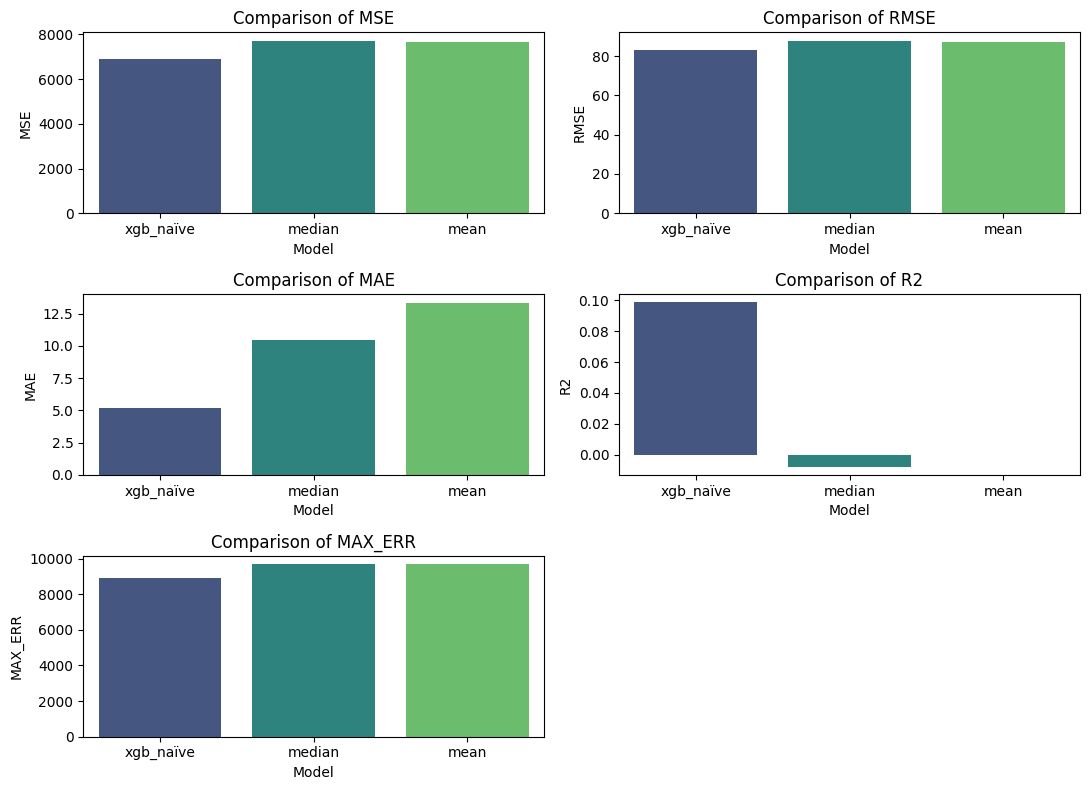

In [55]:
melted_df = all_results.melt(id_vars='model', var_name='metric', value_name='value')
filtered_df = melted_df[melted_df['metric'] != 'avg']
unique_metrics = filtered_df['metric'].unique()
n_metrics = len(unique_metrics)
n_cols = 2
n_rows = (n_metrics + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 8))
axes = axes.flatten()

for i, metric in enumerate(unique_metrics):
    ax = axes[i]
    sns.barplot(
        x='model',
        y='value',
        hue='model',  # Assign 'model' to hue
        data=filtered_df[filtered_df['metric'] == metric],
        palette='viridis',
        ax=ax,
        dodge=False)

    ax.set_title(f'Comparison of {metric.upper()}')
    ax.set_ylabel(metric.upper())
    ax.set_xlabel('Model')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

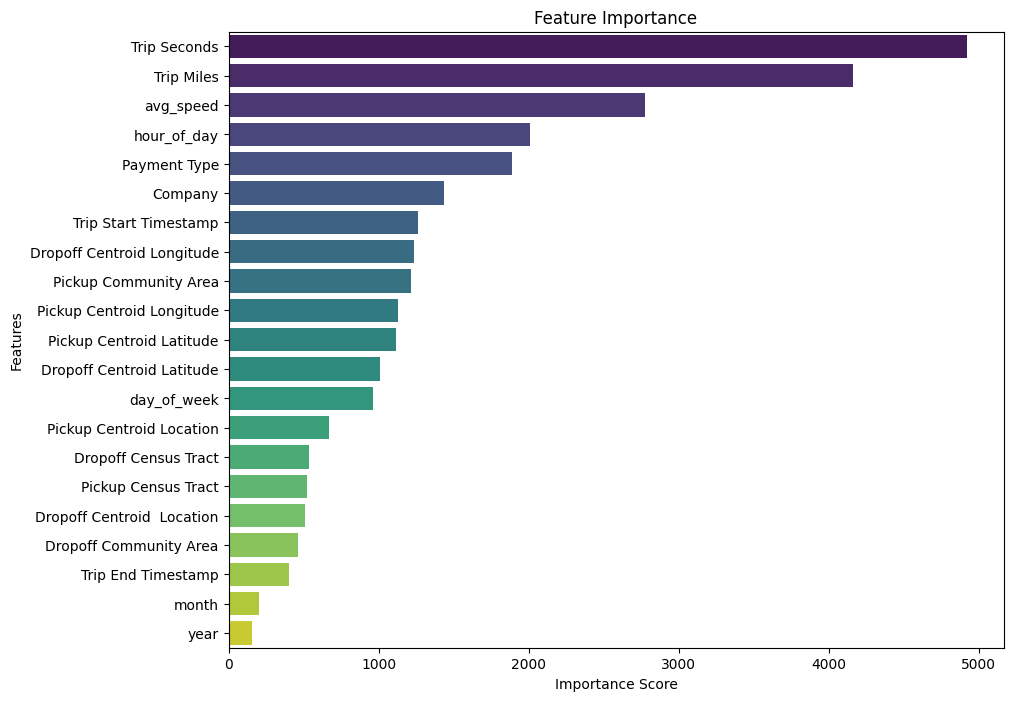

In [56]:
booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')  # You can also use 'gain', 'cover', etc.

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette="viridis", dodge=False, legend=False)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# XGBoost Parameter Tuning

In [57]:
%load_ext cudf.pandas

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [58]:
# !pip install -q optuna

In [59]:
import optuna

In [60]:
df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data
df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name
df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])
df = df.drop(columns=["Trip ID", "Taxi ID"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")

df = df[df["trip_ttl"]>0]
_ = df.nunique().sort_values()

target = ["trip_ttl"]
num_cols = ["Pickup Centroid Latitude", "Pickup Centroid Longitude", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Trip Miles", "Trip Seconds", "Trip Start Timestamp", "Trip End Timestamp"]
cat_cols = list(set(df.columns) - set(target + num_cols))

for col in num_cols:
  df[col] = df[col].fillna(df[col].mean())

df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles", "Payment Type"]]

df = df[(df['Trip Seconds'] * df['Trip Miles']) > 0]

def filter_by_modified_z_score(df, column, threshold=4.0):
    # median and MAD (median abs deviation)
    median = df[column].median()
    mad = (df[column] - median).abs().median()
    return df[(0.6745 * (df[column] - median) / mad).abs() <= threshold]

df = filter_by_modified_z_score(df, "trip_ttl", threshold=3.5)
_ = df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles"]]

### Feature Extraction

df['avg_speed'] = df['Trip Miles'] / (df['Trip Seconds'] / 3600)
num_cols.append('avg_speed')

df['day_of_week'] = df['Trip Start Timestamp'].dt.dayofweek
df['hour_of_day'] = df['Trip Start Timestamp'].dt.hour
df['month'] = df['Trip Start Timestamp'].dt.month
df['year'] = df['Trip Start Timestamp'].dt.year
cat_cols.extend(['day_of_week', 'hour_of_day', 'month', 'year'])

# convert to timestamp seconds since epoch
df['Trip Start Timestamp'] = df['Trip Start Timestamp'].astype(int) // 10**9
df['Trip End Timestamp'] = df['Trip End Timestamp'].astype(int) // 10**9

num_cols.extend(['Trip Start Timestamp', 'Trip End Timestamp'])

for col in cat_cols:
  df[col] = df[col].map(df.groupby(col)["trip_ttl"].mean())

_ = df.sort_values("trip_ttl", ascending=False)

df = df.replace([np.inf, -np.inf], np.nan).dropna()

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [61]:
def xgb_params_objective(trial):

  xgb_params = {
      "device": "cuda",
      "eval_metric": "mae",

      "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),

      "n_estimators": trial.suggest_int("n_estimators", 25, 500),

      "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.9),

      "objective": trial.suggest_categorical("objective", ["reg:squarederror", "reg:squaredlogerror", "reg:gamma", "reg:tweedie"])
  }

  if xgb_params['booster'] == 'gbtree':
      xgb_params["max_depth"] = trial.suggest_int("max_depth", 1, 10)
      xgb_params["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
      xgb_params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)
      xgb_params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.5, 1.0)

  elif xgb_params['booster'] == 'gblinear':
      xgb_params["alpha"] = trial.suggest_float("alpha", 0, 1)
      xgb_params["lambda"] = trial.suggest_float("lambda", 0, 1)
      xgb_params["feature_selector"] = trial.suggest_categorical("feature_selector", ["cyclic", "shuffle"])

  elif xgb_params['booster'] == 'dart':
      xgb_params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
      xgb_params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
      xgb_params["rate_drop"] = trial.suggest_float("rate_drop", 0.0, 1.0)
      xgb_params["skip_drop"] = trial.suggest_float("skip_drop", 0.0, 1.0)

  return xgb_params

In [62]:
def objective(trial):

  xgb_params = xgb_params_objective(trial)

  xgb_auto_tune_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

  X = df.drop(columns=["trip_ttl"])
  y = df["trip_ttl"]

  for fold, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train
    xgb_model = xgb.XGBRegressor(**xgb_params)

    start = time()
    xgb_model.fit(X_train, y_train)
    fit_time = time() - start
    trial.set_user_attr("fit_time", fit_time)

    y_pred = xgb_model.predict(X_test)
    xgb_auto_tune_fold_results["avg"].append(y_pred.mean())

    # metrics
    mse = ((y_test - y_pred) ** 2).mean()
    xgb_auto_tune_fold_results["mse"].append(mse)

    xgb_auto_tune_fold_results["rmse"].append(mse ** 0.5)

    xgb_auto_tune_fold_results["mae"].append((y_test - y_pred).abs().mean())

    ss_residual = ((y_test - y_pred) ** 2).sum()
    ss_total = ((y_test - y_test.mean()) ** 2).sum()
    xgb_auto_tune_fold_results["r2"].append(1 - (ss_residual / ss_total))

    xgb_auto_tune_fold_results["max_err"].append((y_test - y_pred).abs().max())

  xgb_auto_tune_fold_results_df = pd.DataFrame(xgb_auto_tune_fold_results)
  xgb_auto_tune_results_df = pd.DataFrame({'model': 'xgb_auto_tune',
                                           **xgb_auto_tune_fold_results_df.drop(columns=['max_err']).mean(),
                                           'max_err': xgb_auto_tune_fold_results_df['max_err'].max()}, index=[0])


  return xgb_auto_tune_fold_results_df["mae"].mean()

In [63]:
study = optuna.create_study(direction="minimize")

[I 2025-02-03 17:12:50,845] A new study created in memory with name: no-name-041ec309-216e-4095-8039-daf0ad2268e0


In [64]:
!date
study.optimize(objective, timeout=10)
!date

Mon Feb  3 05:12:52 PM EST 2025


[I 2025-02-03 17:12:55,634] Trial 0 finished with value: 0.7064640736026536 and parameters: {'booster': 'gbtree', 'n_estimators': 169, 'learning_rate': 0.10356891544683523, 'objective': 'reg:gamma', 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.705000876057238, 'colsample_bytree': 0.6540427430040263}. Best is trial 0 with value: 0.7064640736026536.
[I 2025-02-03 17:13:07,023] Trial 1 finished with value: 0.7130671593044855 and parameters: {'booster': 'gbtree', 'n_estimators': 493, 'learning_rate': 0.6805445729422043, 'objective': 'reg:squaredlogerror', 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9391656684648917, 'colsample_bytree': 0.5648661103058342}. Best is trial 0 with value: 0.7064640736026536.


Mon Feb  3 05:13:07 PM EST 2025


In [65]:
!date
study.optimize(objective, timeout=10)
!date

Mon Feb  3 05:13:07 PM EST 2025


[I 2025-02-03 17:13:12,967] Trial 2 finished with value: 0.6919382026298602 and parameters: {'booster': 'gbtree', 'n_estimators': 366, 'learning_rate': 0.10916462343447754, 'objective': 'reg:gamma', 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.7709121575535591, 'colsample_bytree': 0.7835041787397603}. Best is trial 2 with value: 0.6919382026298602.
[I 2025-02-03 17:13:16,861] Trial 3 finished with value: 0.6941748858560286 and parameters: {'booster': 'gbtree', 'n_estimators': 86, 'learning_rate': 0.3263622966507713, 'objective': 'reg:squaredlogerror', 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8980998708231533, 'colsample_bytree': 0.8186203782279455}. Best is trial 2 with value: 0.6919382026298602.
[I 2025-02-03 17:14:07,517] Trial 4 finished with value: inf and parameters: {'booster': 'gblinear', 'n_estimators': 210, 'learning_rate': 0.10006859124716823, 'objective': 'reg:gamma', 'alpha': 0.5280859355606613, 'lambda': 0.7463699857662175, 'feature_selector': 'cycli

Mon Feb  3 05:14:07 PM EST 2025


In [66]:
!date
for i in range(6):
    study.optimize(objective, timeout=10, n_jobs=16)
!date

Mon Feb  3 05:38:07 PM EST 2025


[I 2025-02-03 17:39:20,146] Trial 10 finished with value: 699.8120219703021 and parameters: {'booster': 'gblinear', 'n_estimators': 40, 'learning_rate': 0.24964788640527552, 'objective': 'reg:tweedie', 'alpha': 0.6914781052586318, 'lambda': 0.7812559099426765, 'feature_selector': 'shuffle'}. Best is trial 2 with value: 0.6919382026298602.
[I 2025-02-03 17:39:28,165] Trial 17 finished with value: 0.9199419450805543 and parameters: {'booster': 'gbtree', 'n_estimators': 145, 'learning_rate': 0.08571501047500611, 'objective': 'reg:squaredlogerror', 'max_depth': 1, 'min_child_weight': 1, 'subsample': 0.9065252399590654, 'colsample_bytree': 0.7603686045997842}. Best is trial 2 with value: 0.6919382026298602.
[I 2025-02-03 17:39:34,414] Trial 9 finished with value: 0.7272505640206393 and parameters: {'booster': 'gbtree', 'n_estimators': 113, 'learning_rate': 0.8246914046357524, 'objective': 'reg:squarederror', 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8374381740010212, 'colsample_

Mon Feb  3 06:46:15 PM EST 2025
